<font color="#483D8B">
<h1 align="center"> Feature Selection Techniques </h1>
<h3 align="center"> Mahsa Ayoughi</h3>
<h3 align="center"> 10/14/19 </h3>
</font>

## Overview
We need to analyze different feature selection techniques:
* Stepwise selection based on p-values
* Principal component analysis
* Recursive feature elimination
* Feature importance

Data Source: 
Caravan Insurance:https://www.kaggle.com/uciml/caravan-insurance-challenge/home
Stepwise Selection: https://docs.google.com/document/d/1Gfs39-jtahQ3a5eR0zAo3CnftQL_JQLaN7FBg-vrORU/edit


In [236]:
from matplotlib import*
import matplotlib.pyplot as plt
from matplotlib.cm import register_cmap
from scipy import stats
import pandas as pd
import numpy as np
import warnings
from sklearn.svm import SVC
import joblib

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import statsmodels.api as sm
import os
import seaborn as sns


## Data

In [237]:
file = pd.read_csv("/Users/mahsaayoughi/Downloads/caravan-insurance-challenge.csv")
file.head()

,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,train,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,0
1,train,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,0,4,2,4,...,0,0,0,1,0,0,0,0,0,0
3,train,9,1,3,3,3,2,3,2,4,...,0,0,0,1,0,0,0,0,0,0
4,train,40,1,4,2,10,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0


## Exploratory Data Analysis
Using the Caravan Insurance Data, we will be evaluating it with 4 methods: Stepwise Selection, Principal Component Analysis, Recursive Feature Elimination, and Feature Importance.

In [238]:
newfile = file.drop(['ORIGIN'], axis=1).copy()

In [239]:
X,y = newfile.drop(columns='CARAVAN'), newfile.CARAVAN

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
print(y[0:5])
X.head()

0    0
1    0
2    0
3    0
4    0
Name: CARAVAN, dtype: int64


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


## Dimensionality Reduction

In [240]:
def scatter_density(data, labels, sca_title='', den_title='', **kwargs):
    """Plot a scatter plot and a density plot
    Args:
        data : 2-d array, shape (n_samples,2)
        labels: array-like, class labels to be used for coloring scatter plot
        sca_title: str, scatter plot title
        den_title: str, density plot title
        **kwargs: keyword arguments passed to seaborn.kdeplot
    
    Returns: 
        ax, matplotlib axis object
    """
    fig, ax = plt.subplots(1,2,figsize=(10,4),sharey=True,sharex=True)#,gridspec_kw={'width_ratios':[48,48,4]})
    
    dataneg = data[labels == 0]
    datapos = data[labels == 1]
    
    sns.scatterplot(data[:,0], data[:,1],hue=labels, ax=ax[0])
    #sns.scatterplot(dataneg[:,0], dataneg[:,1], palette='Blues', ax=ax[0],alpha=0.06)
    #sns.scatterplot(datapos[:,0], datapos[:,1], palette='Oranges', ax=ax[0],alpha=1)

    sns.kdeplot(datapos[:,0], datapos[:,1], ax=ax[1], cmap='Oranges',**kwargs) #,cbar=True,cbar_ax=ax[2])
    sns.kdeplot(dataneg[:,0], dataneg[:,1], ax=ax[1], cmap='Blues',n_levels=30,**kwargs,shade=True,shade_lowest=False)#,cbar=True,cbar_ax=ax[2])

    ax[0].set_title(sca_title)
    ax[1].set_title(den_title)
    
    fig.tight_layout()
    plt.show()
    return ax

In [241]:
# Summary for numeric independent variables
a.describe()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
count,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,...,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.00000,9822.000000,9822.000000,9822.000000
mean,24.253207,1.108735,2.677561,2.996437,5.779067,0.700672,4.637650,1.050092,3.262981,6.188964,...,0.004582,0.007941,0.004276,0.574018,0.000916,0.005091,0.03146,0.008450,0.013846,0.059662
std,12.918058,0.412101,0.780701,0.804660,2.874148,1.015107,1.721212,1.011156,1.606287,1.896070,...,0.067535,0.088764,0.071224,0.561255,0.030258,0.077996,0.20907,0.092647,0.117728,0.236872
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,30.000000,1.000000,3.000000,3.000000,7.000000,0.000000,5.000000,1.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,35.000000,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,2.000000,4.000000,7.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,41.000000,10.000000,6.000000,6.000000,10.000000,9.000000,9.000000,5.000000,9.000000,9.000000,...,1.000000,1.000000,2.000000,7.000000,1.000000,2.000000,4.00000,2.000000,2.000000,1.000000


### Stepwise Selection

Stepwise selection is an iterative process that repeatedly constructs new models by adding or removing a single predictor and observing the impact on a specified criterion. A threshold can be specified to alter the process by which candidate features are kept or discarded.

In [242]:
def plot_sfs(selector, title='', kind='std_dev', color='blue', bcolor='steelblue', marker='o', 
             alpha=0.2, ylabel=None, confidence_interval=0.95, ax=None, **kwargs):
    allowed = {'std_dev', 'std_err', 'ci', None}
    if kind not in allowed:
        raise AttributeError('kind not in %s' % allowed)

    fig, ax = (plt.gcf(), ax) if ax is not None else plt.subplots(**kwargs)
    
    metric_dict = selector.get_metric_dict()
    k_feat = sorted(metric_dict.keys())
    avg = [metric_dict[k]['avg_score'] for k in k_feat]

    if kind:
        upper, lower = [], []
        if kind == 'ci':
            kind = 'ci_bound'

        for k in k_feat:
            upper.append(metric_dict[k]['avg_score'] + metric_dict[k][kind])
            lower.append(metric_dict[k]['avg_score'] - metric_dict[k][kind])

        ax.fill_between(k_feat, upper, lower, alpha=alpha, color=bcolor, lw=1)

        if kind == 'ci_bound':
            kind = 'Confidence Interval (%d%%)' % (confidence_interval * 100)

    ax.plot(k_feat, avg, color=color, marker=marker)
    ax.set_ylabel(ylabel if ylabel else selector.scoring)
    ax.set_xlabel('Number of Features')
    ax.set_title(title)
    
    feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
    feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
    ax.set_xticks(range(feature_min, feature_max + 1), range(feature_min, feature_max + 1))
    
    return ax


Define a stepwise p-value based feature selection class:

In [243]:
class StepSelect:
    def __init__(self, X, y, threshold_in=0.01, threshold_out=0.05, verbose=True):
        self.X = X
        self.y = y 
        self.threshold_in = threshold_in
        self.threshold_out = threshold_out
        self.verbose = verbose
        assert self.threshold_in < threshold_out, "inclusive p-value should be smaller than exclusive"
        
        self._init_list = []
        self._dlist=[] # dropped values
        self._updated = False # sentinel value
        
    def __call__(self):
        return self._step(self.X, self.y, self._init_list)
        
    def _drop_list(self,add_drop=None):
        """Tracks dropped values"""
        if add_drop is not None:
            self._dlist.append(add_drop) 
        return self._dlist
    
    def _forward(self, included, excluded):
        # forward step
        new_pval = pd.Series(index=excluded)
        for new_col in excluded:
            model = sm.OLS(self.y, sm.add_constant(pd.DataFrame(self.X[included+[new_col]]))).fit()
            new_pval[new_col] = model.pvalues[new_col] # build Series - feat : pvalue

        best_pval = new_pval.min()
        if best_pval < self.threshold_in:
            feat_added = new_pval.idxmin() # name of feature with lowest p-value
            included.append(feat_added)
            self._updated=True
            if self.verbose:
                print('Add  {:30} with p-value {:.6}'.format(feat_added, best_pval))
        
        return included
    
    def _backward(self, included):
        # backward step
        model = sm.OLS(self.y, sm.add_constant(pd.DataFrame(self.X[included]))).fit()
        pvalues = model.pvalues.iloc[1:] 

        worst_pval = pvalues.max()
        if worst_pval > self.threshold_out:
            feat_removed = pvalues.idxmax() # name of feature with highest p-value
            self._drop_list(feat_removed) # add to drop list
            included.remove(feat_removed) # remove from inclusions
            self._updated = True
            if self.verbose:
                print('Drop {:30} with p-value {:.6}'.format(feat_removed, worst_pval))
                
        return included
    
    def _step(self, X, y, included):
        self._updated=False 
        included = list(included)
        excluded = list(set(X.columns)-set(included))

        included = self._forward(included, excluded)
        included = self._backward(included)

        # sanity check for infinite loop, if any value has been dropped 
        # more than twice the number of unique values, return included
        
        drop_vc = pd.Series(self._drop_list()).value_counts()
        is_inf_loop = (drop_vc > 2*len(drop_vc)).any()
        if self._updated and not is_inf_loop:
            return self._step(X, y, included) 
    
        return np.array(included)

In [244]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore',FutureWarning) # Ignore FutureWarning numpy.ptp  
    selected_pval = StepSelect(X,y,threshold_in=0.01,threshold_out=0.05)()

Add  PPERSAUT                       with p-value 2.14684e-42
Add  MKOOPKLA                       with p-value 1.36739e-21
Add  PWAPART                        with p-value 3.66711e-15
Add  APLEZIER                       with p-value 8.20766e-15
Add  MOPLHOOG                       with p-value 4.25236e-06
Add  PBRAND                         with p-value 3.92829e-06
Add  MBERBOER                       with p-value 8.31838e-06
Add  MRELGE                         with p-value 1.41977e-05
Add  PWALAND                        with p-value 0.000361295
Add  ABRAND                         with p-value 0.000937601
Add  AZEILPL                        with p-value 0.00153041
Add  MINK123M                       with p-value 0.00152554
Add  PBYSTAND                       with p-value 0.00243579
Add  PGEZONG                        with p-value 0.00485648
Add  AGEZONG                        with p-value 0.00450709
Add  MHHUUR                         with p-value 0.00630075


As far as I understand, p-values are a very specific interpretation of a single OLS algorithm, and are useful for inference (to decide whether a single predictor matters), but not so useful for prediction (model with lots of bad p-values may have good predictive power, and vice versa)

By using p-values as our criterion, not only do we have the aforementioned issues, now we introduce the Multiple Comparisons Problem.

p-values represent the probability of seeing a test statistic at least as extreme as the one you have, when the null hypothesis is true. If 𝐻0
 is true, the p-value should have a uniform distribution.

But after stepwise selection, the p-values of those terms that remain in the model don't have that property, even when we know that the null hypothesis is true.

This happens because we choose the variables that have or tend to have small p-values. This means that the p-values of the variables left in the model are typically much smaller than they would be if we'd fitted a single model. 

Source: https://stats.stackexchange.com/questions/179941/why-are-p-values-misleading-after-performing-a-stepwise-selection

### Principal Component Analysis
Evaluating Principal Component Analysis on Caravan Insurance Data. The goal of this technique is to reduce the number of d dimensions (features) in a dataset by projecting it to k dimensional subspace where k < d. There are 6 steps needed to complete PCA.
1. Standardize the data
2. Used the data to generate a covariance matrix
3. Obtain eigenvectors (principal components) and eigenvalues from the covariance matrix. Each eigenvector will have a corresponding eigenvalue.
4. Sort the eigenvalues in descending order. 
5. Select the k eigenvectors with the largest eigenvalues, k is the number of dimensions used in the new feature space (k<=d).
6. Construct a new matrix with the selected k eigenvalues. 
Source:https://districtdatalabs.silvrback.com/principal-component-analysis-with-python

In [245]:
#Here we are loading and standardizing the dataset
Xs = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

In [246]:
pca = PCA(random_state=RS)
Xpca=pca.fit_transform(Xs)

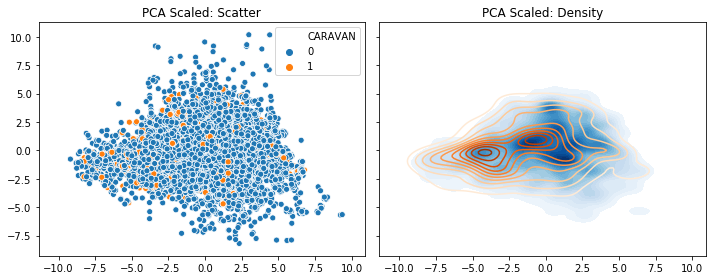

In [247]:
scatter_density(Xpca, y, 'PCA Scaled: Scatter', 'PCA Scaled: Density');

Now we are dealing with the accurate representation of the data, an amorphous point mass.

In [248]:
pca.explained_variance_ratio_[:2]

array([0.11035515, 0.05773411])

About 16% of variance can be explained by these first two abstract components.

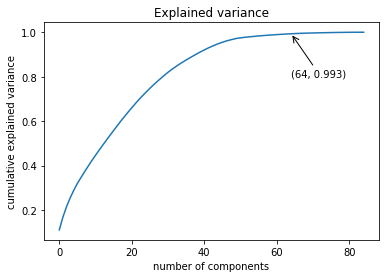

In [249]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.annotate('(64, 0.993)', xy=(64, 0.993), xytext=(64,0.8), fontsize='medium',arrowprops={'arrowstyle':'->','mutation_scale':15})
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Explained variance')
plt.show()

#source: https://gust.dev/python/dimensionality-reduction

As shown in the plot above, around 60% of our cumalitive explained varience lies in the first 18-19 components and by 60 components most varriances are explained.
99.3% of variance can be explained with 64 components, there is a total of 85 componenets which means there are 21 (85-64) number/percent variables with assumed overlapped.

## Models
We will be creating a logistics model using recursive feature elimination, and a random forest classification model outputting feature importance. 

### Recursive Feature Elimination
Evaluating Recursive Feature Elimination on the dataset. This technique works by recursively removing attributes and building a model on those attributes that remain.

Data Source: https://machinelearningmastery.com/feature-selection-machine-learning-python/

In [265]:
# Construct our Linear Regression model
names = ['PPERSAUT', 'MKOOPKLA', 'PWAPART', 'APLEZIER', 
 'MOPLHOOG', 'PBRAND', 'MBERBOER', 'MRELGE', 
 'PWALAND', 'ABRAND', 'AZEILPL', 'MINK123M', 
 'PBYSTAND', 'PGEZONG', 'AGEZONG', 'MHHUUR']
dataframe = pd.DataFrame(names)

model = LogisticRegression(solver='lbfgs', max_iter=500)

#stop the search when only the last feature is left
rfe = RFE(model, n_features_to_select=3)

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [ True False False False False  True  True False]
Feature Ranking: [1 2 4 5 6 1 1 3]


the code above, uses RFE with the logistic regression algorithm to select the top 3 features. 
we know that the ones that are true and have the ranking 1 are the top 3 features.
PPERSAUT, 'PGEZONG' and 'AGEZONG' are the top features

### Feature Importance 
Bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features.You can get the feature importance of each feature of your dataset by using the feature importance property of the model.
Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable. <br/>

Three benefits of performing feature selection before modeling your data are:

Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
Improves Accuracy: Less misleading data means modeling accuracy improves.
Reduces Training Time: Less data means that algorithms train faster.

Source Codes: https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models <br/>
https://machinelearningmastery.com/feature-selection-machine-learning-python/

In [212]:
# Feature Importance with Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)


[0.10434827 0.23525266 0.09098731 0.0836973  0.07982266 0.14220218
 0.10931116 0.15437847]


You can see that we are given an importance score for each attribute where the larger score the more important the attribute. The scores suggest at the importance of 'MKOOPKLA', 'MHHUUR' and 'PGEZONG'.

## Conclusion

Stepwise selection is an iterative process that outputs p-values,helping us understand what the chance is of someone getting an insurance. Pne negetive aspect about this Stepwise selection is being able to add or remove a single predictor and observing and it's possible to alter the process which lowers the accuracy of the data.

with Principal Component Analysis we can reduce the amount of features within the dimensional space. with this method you can decrese the density of your data since most information is clear with only 60% of the data.

Recursive feature elimination this technique works by recursively removing attributes and building a model on those attributes that remain and it will give the top 3 features and similarly in Feature Importance er are givin an importance score for each element in the array.
Looking at a source on the Randon Forest Classification Model, it seems like that average income and car policies showed as the most important features to identify which customers would buy a caravan insurance. 